# Building Tiny YOLO from scratch using PyTorch
In this series we'll go over [YOLO](https://pjreddie.com/darknet/yolo/) (**Y**ou **O**nly **L**ook **O**nce), a state-of the art object detection deep neural network. In this blog post, we'll build the simplest YOLO network: Tiny YOLO v2. This stripped down version of YOLO will yield the easiest introduction to the neural network structure of YOLO, while still providing close to state-of-the-art performance.

## Implementing YOLO in PyTorch
Why would we want to implement YOLO in PyTorch? Didn't the original author already implement YOLO in some framework?

Well, yes, YOLO is implemented in [Darknet](https://pjreddie.com/darknet/), a deep learning framework from the same author as YOLO. And although I have no doubt that this is an excellent framework, it's made for C... I prefer to stick with Python.

However, the specifications for all YOLO networks can be found on [GitHub](https://github.com/pjreddie/darknet/tree/master/cfg) and on the YOLO [homepage](http://pjreddie.com/darknet/yolo). This allows us to quite easily implement these networks with a flexible deep learning framework like PyTorch.

## Short introduction to YOLO
YOLO is a computer vision deep neural network that is specialized in very fast object detection *and* recognition. 

To circumvent the risk of beating a dead horse, here are some excellent resources that explain what YOLO is, why it's special and why it's better than its competitors for fast object detection:

* [The YOLO homepage](https://pjreddie.com/darknet/yolo/)
* [A youtube video of the original talk about YOLO](https://www.youtube.com/watch?v=NM6lrxy0bxs)
* [A youtube video of a talk about a newer YOLO version: YOLOv2 a.k.a. YOLO9000](https://www.youtube.com/watch?v=GBu2jofRJtk)
* [A youtube video showing the performance of the newest version (YOLOv3)](https://www.youtube.com/watch?v=MPU2HistivI)

Here is my relatively short take on it (if it's not immediately clear, it should become more clear once we start implementing it):

YOLO is a deep convolutional neural network that scans an image for objects. The network divides the image into a coarse grid of `32x32` pixel cells. Each cell of the grid predicts a number of object classes with corresponding bounding boxes and a confidence score. The bounding boxes with highest confidence are kept, while the other predicted bounding boxes are ignored.

The number of bounding boxes each cell predicts depends on the number of predefined *anchors*. In fact, since YOLO v2, each cell, only predicts the offset of the bounding box to the middle of the cell and the offset of the size of the bounding box to each predifined anchor.

This all means that bigger images will allow for more predictions to be made (as more `32x32` cells fit into the image). Additionally, the number of predifined anchors directly will also influence the number of predictions made by each cell, and thus the total number of predictions.

Great! For now, you know everything you need to know! Let's move on!

## PASCAL Visual Object Classes dataset
In this part, we will use the PASCAL Visual Object Classes (VOC) dataset. This is a dataset of pictures which are labeled with bounding boxes and corresponding object classes. This dataset contains only `20` quite general classes, which makes it a perfect introductory dataset. Let's download this first. If you try this at home: this takes some time!

In [1]:
import os
import tarfile
import urllib.request

# the VOC object classes.
CLASSES = (
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
)

# download the VOC dataset if it's not already downloaded.
if not os.path.exists("VOCdevkit"):
    if not os.path.exists("VOC.tar"):
        urllib.request.urlretrieve(
            "https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar", "VOC.tar"
        )
    with tarfile.open("VOC.tar") as tar:
        tar.extractall()

Now that we downloaded the VOC data, let's create a function to load the data. The following function will load a **single** image as a PyTorch tensor. Optionally, the image can be resized to a given size by scaling and padding.

In [2]:
import torchvision
from PIL import Image

def load_image(idx, size=None, device="cpu"):
    filename = f"VOCdevkit/VOC2012/JPEGImages/2008_{str(idx).zfill(6)}.jpg"
    img = Image.open(filename)
    transforms = [torchvision.transforms.ToTensor()]
    if size:
        try:
            width, height = size
        except TypeError:
            width = height = size
        scale = min(width / img.width, height / img.height)
        new_width, new_height = int(img.width * scale), int(img.height * scale)
        diff_width, diff_height = width - new_width, height - new_height
        resize = torchvision.transforms.Resize(size=(new_height, new_width))
        pad = torchvision.transforms.Pad(
            padding=(
                diff_width // 2,
                diff_height // 2,
                diff_width // 2 + diff_width % 2,
                diff_height // 2 + diff_height % 2,
            )
        )
        transforms = [resize, pad] + transforms
    transformation = torchvision.transforms.Compose(transforms)
    x = transformation(img).to(device)
    return x

The following function will load multiple images in a batch. This function requires a size to be given to resize each image to. Otherwise the PyTorch tensors cannot be stacked in the first dimension (to form a batch).

In [3]:
import torch

def load_image_batch(idxs, size, device="cpu"):
    imgs = [load_image(idx, size=size, device="cpu") for idx in idxs]
    x = torch.stack(imgs, 0)
    return x.to(device)

Finally, we suspect it might be useful to be able to convert the pytorch tensors back to a PIL Image...

In [4]:
def to_pil(x):
    transform = torchvision.transforms.ToPILImage()
    if x.dim() == 3:  # single image
        return transform(x)
    elif x.dim() == 4:  # batch of images
        return [transform(xx) for xx in x]
    else:
        raise ValueError

... and a way to see the images:

In [5]:
from IPython.display import display

def show_images(x):
    transform = torchvision.transforms.ToPILImage()
    if x.dim() == 3:
        display(transform(x))
    elif x.dim() == 4:
        for xx in x:
            display(transform(xx))
    else:
        raise ValueError

Let's load four images and visualize them:

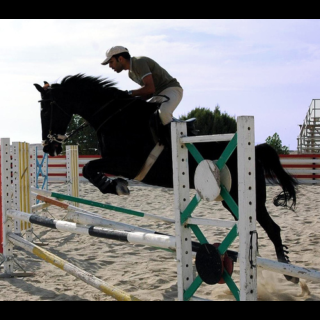

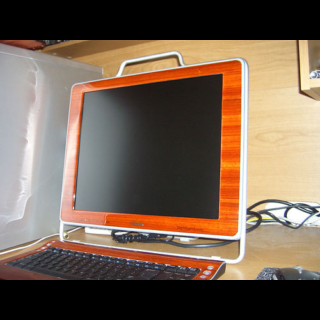

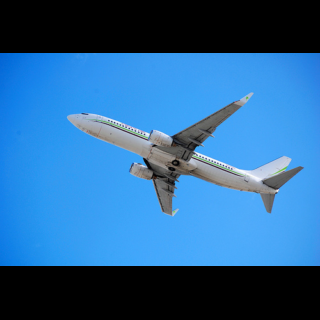

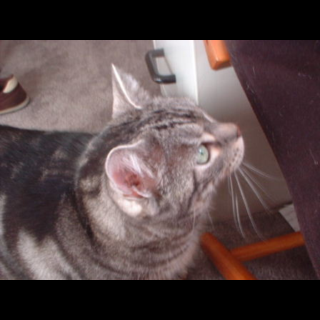

In [6]:
imgs = load_image_batch([8, 16, 33, 60], size=320)
show_images(imgs)

<br>

## Tiny YOLO v2 specification

Tiny YOLO consists of several convolutional layers with leaky ReLU activation. This activation is similar to a normal ReLU activation, but values smaller than zero are multiplied by `0.1` in stead of `0`.

Each of those layers extracts features from the image, followed by pooling layers that downscale the image. In total, there will be `5` pooling layers of size `2` and stride 2, which explains the intuitive notion of a `32x32` grid cell responsible for each prediction as the image is scaled down by a factor of `2⁵=32`.

This means that after the complete convolutial stack, the image of width `W` and height `H` is transformed to a tensor of width `w=W/32` and height `h=H/32`. This Convolutional transformation thus transforms an image of `W*H` pixels into a tensor of `w*h` cells, each of which can be related to the overlayed grid of `32x32` pixel cells.

Each of these cells will now predict a width and height ofsset `(dw, dh)` to the 5 predifined Tiny YOLO anchors: `(1.08,1.19), (3.42,4.41), (6.63,11.38), (9.42,5.11), (16.62,10.52)`. For each of the resulting bounding boxes, an offset `(dx, dy)` to the center `(x0, y0)` of the cell is also predicted along with a confidence of the bounding box `C`.

Assuming we follow the [Tiny YOLO VOC specification](https://github.com/pjreddie/darknet/blob/master/cfg/yolov2-tiny-voc.cfg), we expect the Network to select `1` of `20` classes to predict for each bounding box. This means the network will predict a (softmax) probability for each of the `20` classes to predict on top of the `5` features related to the bounding box itself. This means that the complete convolutional stack will have to transform the image with `3` input channels to a tensor with width `w` and height `h` and depth `125`: `5` bounding box features together with `20` class probabilites for each of the `5` different predifined anchors.

So this is Tiny YOLO v2 in table form:

| &nbsp;#&nbsp; | &nbsp;ImgSize&nbsp; | &nbsp;Layer&nbsp; | &nbsp;Filters&nbsp; | &nbsp;Size&nbsp; | &nbsp;Stride&nbsp; | &nbsp;Pad&nbsp; | &nbsp;Activation&nbsp; |
|:-:|:-:|---|:-:|:-:|:-:|:-:|:-:|
| 0 | 320 | Convolutional  | 16 | 3 | 1 | 1 | leaky ReLU |
| 1 | 320 | MaxPool  | - | 2 | 2 | 0 | - |
| 2 | 160 | Convolutional  | 32 | 3 | 1 | 1 | leaky ReLU |
| 3 | 160 | MaxPool  | - | 2 | 2 | 0 | - |
| 4 | 80 | Convolutional  | 64 | 3 | 1 | 1 | leaky ReLU |
| 5 | 80 | MaxPool  | - | 2 | 2 | 0 | - |
| 6 | 40 | Convolutional  | 128 | 3 | 1 | 1 | leaky ReLU |
| 7 | 40 | MaxPool  | - | 2 | 2 | 0 | - |
| 8 | 20 | Convolutional  | 256 | 3 | 1 | 1 | leaky ReLU |
| 9 | 20 | MaxPool  | - | 2 | 2 | 0 | - |
| 10 | 10 | Convolutional  | 512 | 3 | 1 | 1 | leaky ReLU |
| 11 | 10 | MaxPool  | - | 2 | 1 | 1 | - |
| 12 | 10 | Convolutional  | 1024 | 3 | 1 | 1 | leaky ReLU |
| 13 | 10 | Convolutional  | 1024 | 3 | 1 | 1 | leaky ReLU |
| 14 | 10 | Convolutional  | 125 | 1 | 1 | 1 | - |
| 13 | 10 | Yolo  | - | - | - | - | - |

## Let's build this network in PyTorch, shall we?

In [7]:
import torch

class TinyYOLOv2(torch.nn.Module):
    def __init__(
        self,
        num_classes=20,
        anchors=(
            (1.08, 1.19),
            (3.42, 4.41),
            (6.63, 11.38),
            (9.42, 5.11),
            (16.62, 10.52),
        ),
    ):
        super().__init__()

        # Parameters
        self.register_buffer("anchors", torch.tensor(anchors))
        self.num_classes = num_classes

        # Layers
        self.relu = torch.nn.LeakyReLU(0.1, inplace=True)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.slowpool = torch.nn.MaxPool2d(2, 1)
        self.pad = torch.nn.ReflectionPad2d((0, 1, 0, 1))
        self.norm1 = torch.nn.BatchNorm2d(16, momentum=0.1)
        self.conv1 = torch.nn.Conv2d(3, 16, 3, 1, 1, bias=False)
        self.norm2 = torch.nn.BatchNorm2d(32, momentum=0.1)
        self.conv2 = torch.nn.Conv2d(16, 32, 3, 1, 1, bias=False)
        self.norm3 = torch.nn.BatchNorm2d(64, momentum=0.1)
        self.conv3 = torch.nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        self.norm4 = torch.nn.BatchNorm2d(128, momentum=0.1)
        self.conv4 = torch.nn.Conv2d(64, 128, 3, 1, 1, bias=False)
        self.norm5 = torch.nn.BatchNorm2d(256, momentum=0.1)
        self.conv5 = torch.nn.Conv2d(128, 256, 3, 1, 1, bias=False)
        self.norm6 = torch.nn.BatchNorm2d(512, momentum=0.1)
        self.conv6 = torch.nn.Conv2d(256, 512, 3, 1, 1, bias=False)
        self.norm7 = torch.nn.BatchNorm2d(1024, momentum=0.1)
        self.conv7 = torch.nn.Conv2d(512, 1024, 3, 1, 1, bias=False)
        self.norm8 = torch.nn.BatchNorm2d(1024, momentum=0.1)
        self.conv8 = torch.nn.Conv2d(1024, 1024, 3, 1, 1, bias=False)
        self.conv9 = torch.nn.Conv2d(1024, len(anchors) * (5 + num_classes), 1, 1, 0)

    def forward(self, x):
        x = self.relu(self.pool(self.norm1(self.conv1(x))))
        x = self.relu(self.pool(self.norm2(self.conv2(x))))
        x = self.relu(self.pool(self.norm3(self.conv3(x))))
        x = self.relu(self.pool(self.norm4(self.conv4(x))))
        x = self.relu(self.pool(self.norm5(self.conv5(x))))
        x = self.relu(self.slowpool(self.pad(self.norm6(self.conv6(x)))))
        x = self.relu(self.norm7(self.conv7(x)))
        x = self.relu(self.norm8(self.conv8(x)))
        x = self.yolo(self.conv9(x))
        return x

    def yolo(self, x):
        # store the original shape of x
        b, _, h, w = x.shape

        # reshape the x-tensor: (batch size, # anchors, h, w, 5+num_classes)
        x = x.view(b, self.anchors.shape[0], -1, h, w).permute(0, 1, 3, 4, 2)

        # compute activations
        x[:, :, :, :, :2] = x[:, :, :, :, :2].sigmoid()
        x[:, :, :, :, 2:4] = x[:, :, :, :, 2:4].exp()
        x[:, :, :, :, 4] = x[:, :, :, :, 4].sigmoid()
        x[:, :, :, :, 5:] = torch.nn.functional.softmax(x[:, :, :, :, 5:], -1)

        # get normalized auxiliary tensors
        range_y, range_x = [
            lin[None, None]
            for lin in torch.meshgrid(
                torch.arange(h, dtype=x.dtype, device=x.device),
                torch.arange(w, dtype=x.dtype, device=x.device),
            )
        ]
        anchor_x = self.anchors[None, :, :1, None].to(dtype=x.dtype, device=x.device)
        anchor_y = self.anchors[None, :, None, 1:].to(dtype=x.dtype, device=x.device)

        # compute boxes.
        x[:, :, :, :, 0] = (x[:, :, :, :, 0] + range_x) / w  # X center
        x[:, :, :, :, 1] = (x[:, :, :, :, 1] + range_y) / h  # Y center
        x[:, :, :, :, 2] = x[:, :, :, :, 2] * anchor_x / w  # Width
        x[:, :, :, :, 3] = x[:, :, :, :, 3] * anchor_y / h  # Height

        return x

## First prediction of an untrained network

Let's see what would happen if we use Tiny YOLO on an image of an airplane:

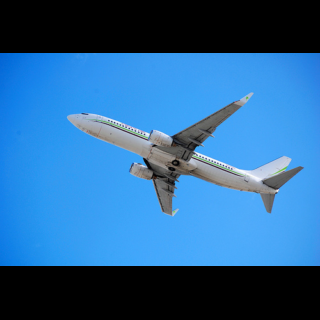

torch.Size([1, 5, 10, 10, 25])


In [8]:
network = TinyYOLOv2()
input_tensor = load_image_batch([33], 320) # batch with single image of an airplane
show_images(input_tensor)
output_tensor = network(input_tensor)
print(output_tensor.shape)

As you can see, the result of the propagation of the image through the network is a `1x5x13x13x25` tensor: `1` single element in the batch, `5` anchors, `13x13` cells and `25` features predicted per cell and per anchor.

The first `5` features of those `25` features in the last dimension describe the bounding boxes, while the next `20` features describe the (softmax) probability for the bounding box containing each of the `20` possible classes.

We can try to visualize the bounding boxes predicted:

In [9]:
from PIL import ImageDraw

def show_images_with_boxes(input_tensor, output_tensor):
    to_img = torchvision.transforms.ToPILImage()
    for img, predictions in zip(input_tensor, output_tensor):
        img = to_img(img)
        if not 0 in predictions.shape:
            confidences = predictions[..., 4].flatten()
            boxes = (
                predictions[..., :4].contiguous().view(-1, 4)
            )  # only take first four features: x0, y0, w, h
            classes = predictions[..., 5:].contiguous().view(boxes.shape[0], -1)
            boxes[:, ::2] *= img.width
            boxes[:, 1::2] *= img.height
            boxes = (
                torch.stack(
                    [
                        boxes[:, 0] - boxes[:, 2] / 2,
                        boxes[:, 1] - boxes[:, 3] / 2,
                        boxes[:, 0] + boxes[:, 2] / 2,
                        boxes[:, 1] + boxes[:, 3] / 2,
                    ],
                    -1,
                )
                .cpu()
                .to(torch.int32)
                .numpy()
            )
            for box, confidence, class_ in zip(boxes, confidences, classes):
                # make sure the box fits within the picture:
                box = [
                    max(0, int(box[0])),
                    max(0, int(box[1])),
                    min(img.width - 1, int(box[2])),
                    min(img.height - 1, int(box[3])),
                ]
                try:  # either the class is given as the sixth feature
                    idx = int(class_.item())
                except ValueError:  # or the 20 softmax probabilities are given as features 6-25
                    idx = int(torch.max(class_, 0)[1].item())
                try:
                    class_ = CLASSES[idx]  # the first index of torch.max is the argmax.
                except IndexError: # if the class index does not exist, default "None":
                    class_ = "None"
                    
                color = (  # green color when confident, red color when not confident.
                    int((1 - confidence.item()) * 255),
                    int(confidence.item() * 255),
                    0,
                )

                draw = ImageDraw.Draw(img)
                draw.rectangle(box, outline=color)
                draw.text(box[:2], class_, fill=color)

        display(img)

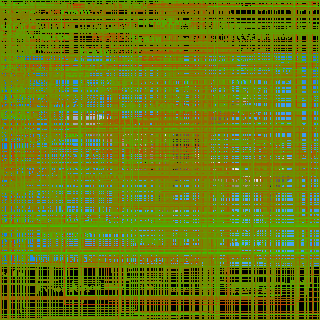

In [10]:
show_images_with_boxes(input_tensor, output_tensor)

Unfortunately, right now, the network does not make any sensible predictions yet, as it is not yet trained. For now, we can skip the training and load the pre-trained weights into the network. Training the YOLO network will be handled in the next part of this series.

## Loading pretrained YOLO weights
Pretrained weights for the Tiny YOLO v2 network trained on the VOC dataset can be downloaded from the darknet website (again, if you're trying this at home: this takes some time to download):

In [11]:
if not os.path.exists("yolov2-tiny-voc.weights"):
    urllib.request.urlretrieve(
        "https://pjreddie.com/media/files/yolov2-tiny-voc.weights",
        "yolov2-tiny-voc.weights",
    )

This is just a binary file, with all the weights for each layer stored in sequence. The first three integers in this binary file denote the version of the weight file and the next integer denotes the number of images the network has seen so far to obtain these weights. The following numbers are all of type float32 and denote all the weights in all the layers. Let's create a function to load the weights:

In [12]:
import numpy as np

def load_weights(network, filename="yolov2-tiny-voc.weights"):
    with open(filename, "rb") as file:
        version = np.fromfile(file, count=3, dtype=np.int32)
        seen_so_far = np.fromfile(file, count=1, dtype=np.int32)
        weights = np.fromfile(file, dtype=np.float32)
        idx = 0
        for layer in network.children():
            if isinstance(layer, torch.nn.Conv2d):
                if layer.bias is not None:
                    n = layer.bias.numel()
                    layer.bias.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.bias.data)
                    idx += n
                n = layer.weight.numel()
                layer.weight.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.weight.data)
                idx += n
            if isinstance(layer, torch.nn.BatchNorm2d):
                n = layer.bias.numel()
                layer.bias.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.bias.data)
                idx += n
                layer.weight.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.weight.data)
                idx += n
                layer.running_mean.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.running_mean)
                idx += n
                layer.running_var.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.running_var)
                idx += n
            if isinstance(layer, torch.nn.Linear):
                n = layer.bias.numel()
                layer.bias.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.bias.data)
                idx += n
                n = layer.weight.numel()
                layer.weight.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.weight.data)
                idx += n

Let's load the weights:

In [13]:
load_weights(network)

## Retrieve the bounding boxes from a prediction

Remember the image of the airplane, we received a (1, 5, 13, 13, 25) sized tensor with predictions from our network. We still have to translate those to bounding boxes.

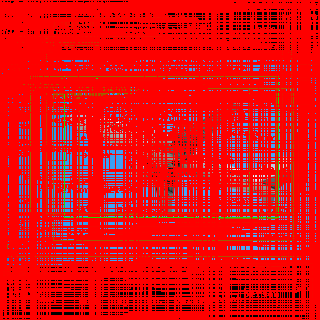

In [14]:
input_tensor = load_image_batch([33], 320)  # batch with single image of an airplane
output_tensor = network(input_tensor)
show_images_with_boxes(input_tensor, output_tensor)

You see? of the majority of the boxes predicted, the confidence is very low (red boxes), while there are only a few green boxes visible if you look very carefully. Now we only need to filter out the predictions with the highest confidence values. Also, we are probably not interested in the scores for all possible classes, we only need the class label for the class corresponding best with the found object in the box:

In [15]:
output_tensor.shape

torch.Size([1, 5, 10, 10, 25])

In [16]:
def filter_boxes(output_tensor, threshold):
    b, a, h, w, c = output_tensor.shape
    x = output_tensor.contiguous().view(b, a * h * w, c)

    boxes = x[:, :, 0:4]
    confidence = x[:, :, 4]
    scores, idx = torch.max(x[:, :, 5:], -1)
    idx = idx.float()
    scores = scores * confidence
    mask = scores > threshold

    filtered = []
    for c, s, i, m in zip(boxes, scores, idx, mask):
        if m.any():
            detected = torch.cat([c[m, :], s[m, None], i[m, None]], -1)
        else:
            detected = torch.zeros((0, 6), dtype=x.dtype, device=x.device)
        filtered.append(detected)
    return filtered

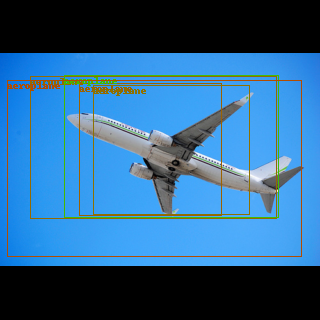

In [17]:
filtered_tensor = filter_boxes(output_tensor, 0.2)
show_images_with_boxes(input_tensor, filtered_tensor)

We see a bunch of bounding boxes surrounding the airplane after filtering. We also see that the classlabel `aeroplane` seems to be correct! However, ideally we just want a single bounding box per object...

## Non Maximum Suppression

We can use non-maximum suppression (NMS) to filter out boxes with high overlap. The amount of overlap between boxes can be quantified by the [Intersection over Union](https://en.wikipedia.org/wiki/Jaccard_index) (IoU).

In [18]:
def iou(bboxes):
    xc, yc, width, height = bboxes[...,:4].split(1, -1)
    x1, y1, x2, y2 = xc - 0.5 * width, yc - 0.5 * height, xc + 0.5 * width, yc + 0.5 * height
    zero = torch.tensor(0.0, dtype=x1.dtype, device=x1.device)
    dx = torch.max(torch.min(x2, x2.T) - torch.max(x1, x1.T), zero)
    dy = torch.max(torch.min(y2, y2.T) - torch.max(y1, y1.T), zero)
    intersections = dx * dy
    areas = (x2 - x1) * (y2 - y1)
    unions = (areas + areas.t()) - intersections
    return intersections / unions


def nms(filtered_tensor, threshold):
    result = []
    for x in filtered_tensor:
        # Sort coordinates by descending score
        scores, order = x[:, 4].sort(0, descending=True)
        x = x[order]
        ious = iou(x)

        # Filter based on iou
        keep = (ious > threshold).long().triu(1).sum(0, keepdim=True).t().expand_as(x) == 0

        result.append(x[keep].view(-1, 6).contiguous())
    return result

Let's see what NMS can do for us:

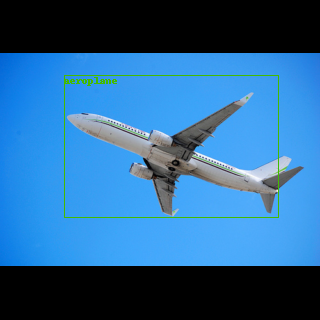

In [19]:
nms_tensor = nms(filtered_tensor, 0.5)
show_images_with_boxes(input_tensor, nms_tensor)

## Final detections

Finally, we look at some more images.

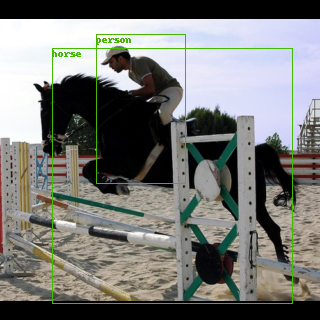

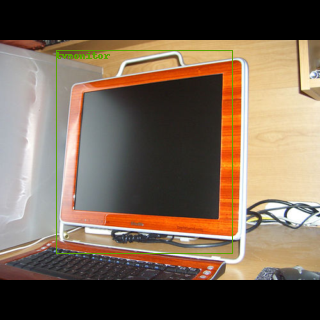

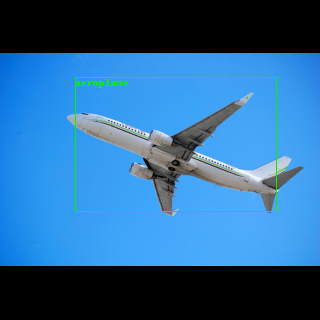

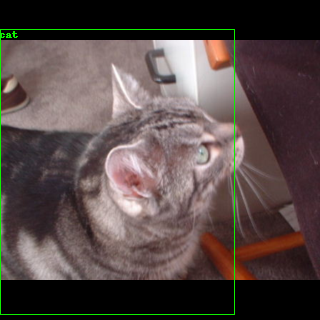

In [20]:
imgs = load_image_batch([8, 16, 33, 60], size=320)
output_tensor = network(imgs)
filtered_tensor = filter_boxes(output_tensor, 0.2)
nms_tensor = nms(filtered_tensor, 0.5)
show_images_with_boxes(imgs, nms_tensor)